# Gradient Boosting - Microstructure Prediction

**Objective:** Train Gradient Boosting classifiers and compare sequential boosting vs. bagging (Random Forest).

**Inputs:**

- Features with regimes from notebook 30 (`AAPL_features_with_regimes.parquet`)
- Baseline results from notebook 35
- Decision Tree results from notebook 40
- Random Forest results from notebook 45
- **Time period:** December 9-13, 2024 (5 trading days)

**Models:**

- Gradient Boosting Classifier (standard GBM)
- HistGradientBoosting Classifier (optimized for large datasets)
- Hyperparameter tuning: learning_rate, max_depth, n_estimators, early stopping

**Outputs:**

- Tuned Gradient Boosting models
- Performance comparison vs. Random Forest, Decision Tree, and baseline
- Feature importance analysis
- Learning curves and early stopping analysis
- Boosting vs. bagging comparison

**Target Variable:** Next-period mid-price direction (up=1, down=0)


## 1. Setup and Imports


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import json
import time
import warnings

warnings.filterwarnings("ignore")

# Sklearn imports
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
    log_loss,
)

# Visualization
plt.style.use("seaborn-v0_8-paper")
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.weight": "bold",
        "axes.labelweight": "bold",
        "axes.titleweight": "bold",
        "axes.linewidth": 1.2,
        "axes.spines.top": False,
        "axes.spines.right": False,
    }
)

# Import project config
import sys

sys.path.append("..")
from src.config import PROCESSED_DATA_DIR, MODELS_DIR, FIGURES_DIR, TABLES_DIR

# Create output directories
gb_dir = FIGURES_DIR / "gradient_boosting"
gb_dir.mkdir(parents=True, exist_ok=True)

# Set random seed
np.random.seed(42)

print(" Setup complete")
print(f"  Data directory: {PROCESSED_DATA_DIR}")
print(f"  Models directory: {MODELS_DIR}")
print(f"  Figures directory: {gb_dir}")

 Setup complete
  Data directory: /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../data/processed
  Models directory: /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../models
  Figures directory: /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/figures/gradient_boosting


In [2]:
# Configuration
TICKER = "AAPL"
START_DATE = "2024-12-09"  # Start date for multi-day data
END_DATE = "2024-12-13"  # End date for multi-day data
DATE_RANGE = f"{START_DATE}_to_{END_DATE}"  # File naming convention

print(f"Ticker: {TICKER}")
print(f"Date range: {START_DATE} to {END_DATE}")
print(f"Working with 5 days of data for gradient boosting training")

Ticker: AAPL
Date range: 2024-12-09 to 2024-12-13
Working with 5 days of data for gradient boosting training


## 2. Load Data and Previous Results


In [3]:
# Load features with regimes from notebook 30
print("Loading features with regimes...")
features_with_regimes = pd.read_parquet(
    PROCESSED_DATA_DIR / "AAPL_features_with_regimes.parquet"
).reset_index(drop=True)

print(f" Features with regimes: {features_with_regimes.shape}")

# Load previous results for comparison
with open(MODELS_DIR / "baseline_results.json", "r") as f:
    baseline_results = json.load(f)

with open(MODELS_DIR / "decision_tree_results.json", "r") as f:
    dt_results = json.load(f)

with open(MODELS_DIR / "random_forest_results.json", "r") as f:
    rf_results = json.load(f)

print("\n Loaded previous results")
print(f"\nBaseline (Logistic Regression L2):")
print(f"  Test Accuracy: {baseline_results['lr_l2']['test_accuracy']:.4f}")
print(f"  Test F1:       {baseline_results['lr_l2']['test_f1']:.4f}")
print(f"  Test ROC-AUC:  {baseline_results['lr_l2']['test_roc_auc']:.4f}")

print(f"\nDecision Tree (Tuned):")
print(f"  Test Accuracy: {dt_results['dt_tuned']['test_accuracy']:.4f}")
print(f"  Test F1:       {dt_results['dt_tuned']['test_f1']:.4f}")
print(f"  Test ROC-AUC:  {dt_results['dt_tuned']['test_roc_auc']:.4f}")

print(f"\nRandom Forest (Tuned):")
print(f"  Test Accuracy: {rf_results['rf_tuned']['test_accuracy']:.4f}")
print(f"  Test F1:       {rf_results['rf_tuned']['test_f1']:.4f}")
print(f"  Test ROC-AUC:  {rf_results['rf_tuned']['test_roc_auc']:.4f}")

Loading features with regimes...
 Features with regimes: (1365, 94)

 Loaded previous results

Baseline (Logistic Regression L2):
  Test Accuracy: 0.6813
  Test F1:       0.6667
  Test ROC-AUC:  0.7337

Decision Tree (Tuned):
  Test Accuracy: 0.6374
  Test F1:       0.6689
  Test ROC-AUC:  0.6313

Random Forest (Tuned):
  Test Accuracy: 0.6300
  Test F1:       0.6354
  Test ROC-AUC:  0.6945


## 3. Create Target Variable and Features


In [4]:
# Find price column
price_candidates = ["agg_mid_price", "agg_close", "mid_price", "close"]
price_col = next(
    (col for col in price_candidates if col in features_with_regimes.columns), None
)

if price_col is None:
    raise ValueError(
        f"No price column found. Available columns: {features_with_regimes.columns.tolist()[:20]}"
    )

print(f"Using price column: {price_col}")

# Create target: 1 if next price > current price, 0 otherwise
features_with_regimes["price_next"] = features_with_regimes[price_col].shift(-1)
features_with_regimes["target"] = (
    features_with_regimes["price_next"] > features_with_regimes[price_col]
).astype(int)

# Remove last row (no future price)
features_with_regimes = features_with_regimes[:-1].copy()

print(f"\n Target variable created")
print(f"  Shape: {features_with_regimes.shape}")

Using price column: agg_mid_price

 Target variable created
  Shape: (1364, 96)


## 4. Feature Selection and Cleaning


In [5]:
# Columns to exclude from features
exclude_cols = [
    "timestamp",
    "target",
    "price_next",
    "regime_hmm",
    "regime_hawkes",
    "regime_hawkes_binary",
    "hmm_state",
    "time_hour",
    "time_minute",
    "time_minutes_since_open",
    "time_session",
    "hour",
    "minute",
    "time_of_day",
]

# Get feature columns
feature_cols = [col for col in features_with_regimes.columns if col not in exclude_cols]

# Select only numeric features
X = features_with_regimes[feature_cols].select_dtypes(include=[np.number])
feature_cols = X.columns.tolist()

# Get target
y = features_with_regimes["target"].values

# Handle missing and infinite values
X = X.fillna(method="ffill").fillna(method="bfill").fillna(0)
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

print(f" Feature matrix: {X.shape}")
print(f" Target vector: {y.shape}")

 Feature matrix: (1364, 81)
 Target vector: (1364,)


## 5. Train-Test Split (Time-Series)


In [6]:
# Time-series split (no shuffling)
split_idx = int(len(X) * 0.8)

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

print(f"Train set: {X_train.shape[0]:,} samples ({100*len(X_train)/len(X):.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({100*len(X_test)/len(X):.1f}%)")

Train set: 1,091 samples (80.0%)
Test set: 273 samples (20.0%)


## 6. Baseline Gradient Boosting

Train with default parameters


In [7]:
# Train baseline gradient boosting
print("Training baseline Gradient Boosting (100 estimators, default parameters)...")

gb_baseline = GradientBoostingClassifier(n_estimators=100, random_state=42)

start_time = time.time()
gb_baseline.fit(X_train, y_train)
train_time = time.time() - start_time

# Predictions
y_train_pred_base = gb_baseline.predict(X_train)
y_test_pred_base = gb_baseline.predict(X_test)
y_test_proba_base = gb_baseline.predict_proba(X_test)[:, 1]

# Metrics
print("\n" + "=" * 80)
print("BASELINE GRADIENT BOOSTING (100 estimators, default parameters)")
print("=" * 80)

print(f"\nTraining time: {train_time:.2f} seconds")
print(f"Number of estimators: {gb_baseline.n_estimators}")
print(f"Learning rate: {gb_baseline.learning_rate}")
print(f"Max depth: {gb_baseline.max_depth}")

print("\nTRAIN SET:")
print(f"  Accuracy:  {accuracy_score(y_train, y_train_pred_base):.4f}")
print(f"  Precision: {precision_score(y_train, y_train_pred_base):.4f}")
print(f"  Recall:    {recall_score(y_train, y_train_pred_base):.4f}")
print(f"  F1-score:  {f1_score(y_train, y_train_pred_base):.4f}")

print("\nTEST SET:")
print(f"  Accuracy:  {accuracy_score(y_test, y_test_pred_base):.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred_base):.4f}")
print(f"  Recall:    {recall_score(y_test, y_test_pred_base):.4f}")
print(f"  F1-score:  {f1_score(y_test, y_test_pred_base):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_test, y_test_proba_base):.4f}")

# Compare to Random Forest
print("\nCOMPARISON TO RANDOM FOREST:")
rf_test_acc = rf_results["rf_tuned"]["test_accuracy"]
rf_test_f1 = rf_results["rf_tuned"]["test_f1"]
gb_test_acc = accuracy_score(y_test, y_test_pred_base)
gb_test_f1 = f1_score(y_test, y_test_pred_base)

print(
    f"  Accuracy:  {gb_test_acc - rf_test_acc:+.4f} ({100*(gb_test_acc - rf_test_acc)/rf_test_acc:+.1f}%)"
)
print(
    f"  F1-score:  {gb_test_f1 - rf_test_f1:+.4f} ({100*(gb_test_f1 - rf_test_f1)/rf_test_f1:+.1f}%)"
)

Training baseline Gradient Boosting (100 estimators, default parameters)...

BASELINE GRADIENT BOOSTING (100 estimators, default parameters)

Training time: 2.78 seconds
Number of estimators: 100
Learning rate: 0.1
Max depth: 3

TRAIN SET:
  Accuracy:  0.9083
  Precision: 0.9268
  Recall:    0.8720
  F1-score:  0.8986

TEST SET:
  Accuracy:  0.6740
  Precision: 0.7203
  Recall:    0.6028
  F1-score:  0.6564
  ROC-AUC:   0.7144

COMPARISON TO RANDOM FOREST:
  Accuracy:  +0.0440 (+7.0%)
  F1-score:  +0.0210 (+3.3%)


## 7. Learning Rate Analysis

Test different learning rates to understand bias-variance tradeoff


In [8]:
# Test different learning rates
print("Testing different learning rates...")

learning_rates = [0.01, 0.05, 0.1, 0.2, 0.3]
lr_results = []

for lr in learning_rates:
    print(f"  Training with learning_rate={lr}...", end=" ")

    gb = GradientBoostingClassifier(
        n_estimators=200, learning_rate=lr, max_depth=5, random_state=42
    )

    start_time = time.time()
    gb.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Predictions
    y_train_pred = gb.predict(X_train)
    y_test_pred = gb.predict(X_test)
    y_test_proba = gb.predict_proba(X_test)[:, 1]

    lr_results.append(
        {
            "learning_rate": lr,
            "train_time": train_time,
            "train_acc": accuracy_score(y_train, y_train_pred),
            "test_acc": accuracy_score(y_test, y_test_pred),
            "test_f1": f1_score(y_test, y_test_pred),
            "test_roc_auc": roc_auc_score(y_test, y_test_proba),
            "overfit_gap": accuracy_score(y_train, y_train_pred)
            - accuracy_score(y_test, y_test_pred),
        }
    )

    print(f"done ({train_time:.1f}s)")

lr_df = pd.DataFrame(lr_results)

print("\n" + "=" * 80)
print("LEARNING RATE ANALYSIS")
print("=" * 80)
print(lr_df.to_string(index=False))

# Find optimal learning rate
optimal_idx = lr_df["test_f1"].idxmax()
optimal_lr = lr_df.loc[optimal_idx, "learning_rate"]
print(f"\n Optimal learning_rate: {optimal_lr}")
print(f"  Test F1-score: {lr_df.loc[optimal_idx, 'test_f1']:.4f}")

Testing different learning rates...
  Training with learning_rate=0.01... done (8.7s)
  Training with learning_rate=0.05... done (8.9s)
  Training with learning_rate=0.1... done (8.1s)
  Training with learning_rate=0.2... done (8.1s)
  Training with learning_rate=0.3... done (8.1s)

LEARNING RATE ANALYSIS
 learning_rate  train_time  train_acc  test_acc  test_f1  test_roc_auc  overfit_gap
          0.01    8.738324   0.898258  0.663004 0.661765      0.691167     0.235255
          0.05    8.921286   0.999083  0.641026 0.639706      0.712229     0.358058
          0.10    8.118046   1.000000  0.644689 0.613546      0.716742     0.355311
          0.20    8.112607   1.000000  0.641026 0.625954      0.694552     0.358974
          0.30    8.140320   1.000000  0.604396 0.560976      0.694928     0.395604

 Optimal learning_rate: 0.01
  Test F1-score: 0.6618


## 8. Visualize Learning Rate Analysis


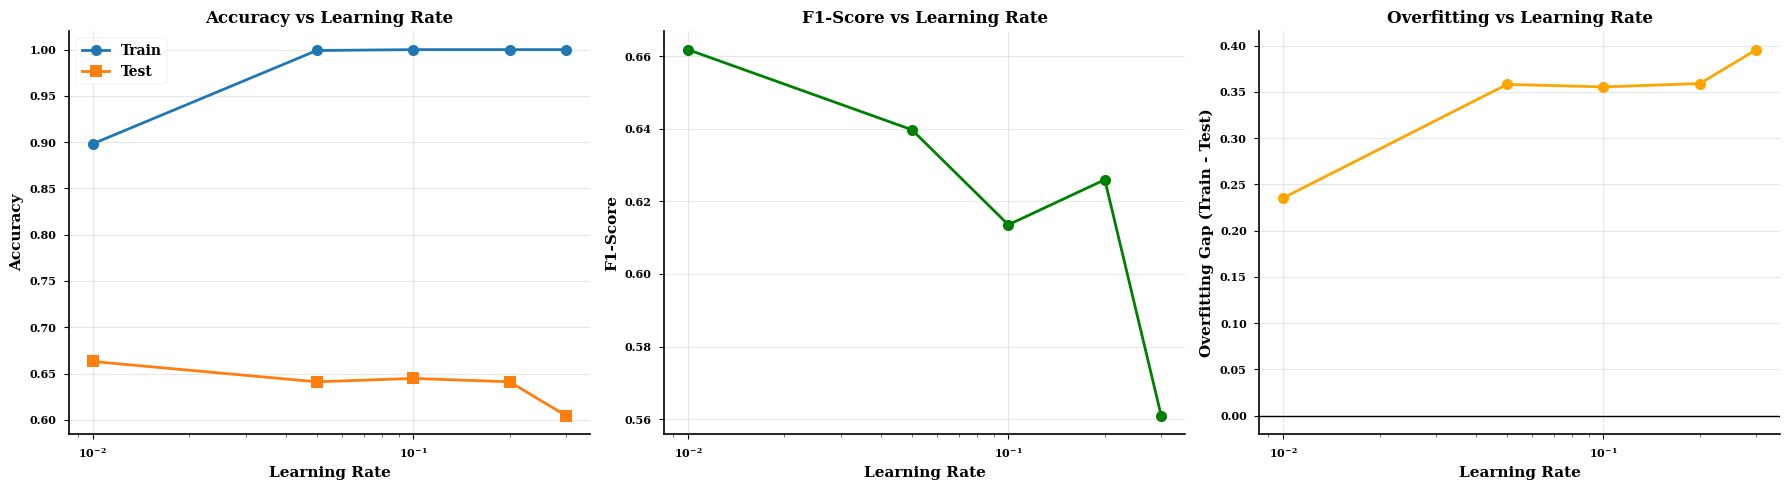


 Saved to /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/figures/gradient_boosting/learning_rate_analysis.png


In [9]:
# Plot learning rate analysis
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Accuracy vs Learning Rate
axes[0].plot(
    lr_df["learning_rate"],
    lr_df["train_acc"],
    "o-",
    linewidth=2,
    markersize=8,
    label="Train",
)
axes[0].plot(
    lr_df["learning_rate"],
    lr_df["test_acc"],
    "s-",
    linewidth=2,
    markersize=8,
    label="Test",
)
axes[0].set_xlabel("Learning Rate", fontsize=11)
axes[0].set_ylabel("Accuracy", fontsize=11)
axes[0].set_title("Accuracy vs Learning Rate", fontsize=12, fontweight="bold")
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].set_xscale("log")

# Plot 2: F1-score vs Learning Rate
axes[1].plot(
    lr_df["learning_rate"],
    lr_df["test_f1"],
    "o-",
    linewidth=2,
    markersize=8,
    color="green",
)
axes[1].set_xlabel("Learning Rate", fontsize=11)
axes[1].set_ylabel("F1-Score", fontsize=11)
axes[1].set_title("F1-Score vs Learning Rate", fontsize=12, fontweight="bold")
axes[1].grid(alpha=0.3)
axes[1].set_xscale("log")

# Plot 3: Overfitting Gap vs Learning Rate
axes[2].plot(
    lr_df["learning_rate"],
    lr_df["overfit_gap"],
    "o-",
    linewidth=2,
    markersize=8,
    color="orange",
)
axes[2].axhline(y=0, color="black", linestyle="-", linewidth=1)
axes[2].set_xlabel("Learning Rate", fontsize=11)
axes[2].set_ylabel("Overfitting Gap (Train - Test)", fontsize=11)
axes[2].set_title("Overfitting vs Learning Rate", fontsize=12, fontweight="bold")
axes[2].grid(alpha=0.3)
axes[2].set_xscale("log")

plt.tight_layout()
plt.savefig(gb_dir / "learning_rate_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n Saved to {gb_dir / 'learning_rate_analysis.png'}")

## 9. Hyperparameter Tuning with Randomized Search

Tune learning_rate, max_depth, n_estimators, min_samples_split


In [10]:
# Define parameter distributions
param_distributions = {
    "n_estimators": [100, 150, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
    "max_depth": [3, 4, 5, 6, 7, 8],
    "min_samples_split": [20, 50, 100],
    "min_samples_leaf": [10, 20, 50],
    "subsample": [0.8, 0.9, 1.0],
}

print("Hyperparameter tuning with RandomizedSearchCV...")
print(f"Parameter distributions:")
for param, values in param_distributions.items():
    print(f"  {param}: {values}")

# Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search (sample 50 combinations)
random_search = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=42),
    param_distributions=param_distributions,
    n_iter=50,
    cv=tscv,
    scoring="f1",
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

print(f"\nTesting {random_search.n_iter} parameter combinations...")
random_search.fit(X_train, y_train)

print("\n" + "=" * 80)
print("RANDOMIZED SEARCH RESULTS")
print("=" * 80)
print(f"\nBest parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nBest cross-validation F1-score: {random_search.best_score_:.4f}")

Hyperparameter tuning with RandomizedSearchCV...
Parameter distributions:
  n_estimators: [100, 150, 200, 300]
  learning_rate: [0.01, 0.05, 0.1, 0.15, 0.2]
  max_depth: [3, 4, 5, 6, 7, 8]
  min_samples_split: [20, 50, 100]
  min_samples_leaf: [10, 20, 50]
  subsample: [0.8, 0.9, 1.0]

Testing 50 parameter combinations...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

RANDOMIZED SEARCH RESULTS

Best parameters:
  subsample: 0.8
  n_estimators: 300
  min_samples_split: 100
  min_samples_leaf: 50
  max_depth: 5
  learning_rate: 0.01

Best cross-validation F1-score: 0.6518


## 10. Train Final Tuned Model


In [11]:
# Get best model from randomized search
gb_tuned = random_search.best_estimator_

# Predictions
y_train_pred_tuned = gb_tuned.predict(X_train)
y_test_pred_tuned = gb_tuned.predict(X_test)
y_test_proba_tuned = gb_tuned.predict_proba(X_test)[:, 1]

# Metrics
print("=" * 80)
print("TUNED GRADIENT BOOSTING PERFORMANCE")
print("=" * 80)

print(f"\nModel configuration:")
print(f"  Number of estimators: {gb_tuned.n_estimators}")
print(f"  Learning rate: {gb_tuned.learning_rate}")
print(f"  Max depth: {gb_tuned.max_depth}")
print(f"  Min samples split: {gb_tuned.min_samples_split}")
print(f"  Min samples leaf: {gb_tuned.min_samples_leaf}")
print(f"  Subsample: {gb_tuned.subsample}")

print("\nTRAIN SET:")
print(f"  Accuracy:  {accuracy_score(y_train, y_train_pred_tuned):.4f}")
print(f"  Precision: {precision_score(y_train, y_train_pred_tuned):.4f}")
print(f"  Recall:    {recall_score(y_train, y_train_pred_tuned):.4f}")
print(f"  F1-score:  {f1_score(y_train, y_train_pred_tuned):.4f}")

print("\nTEST SET:")
test_acc_tuned = accuracy_score(y_test, y_test_pred_tuned)
test_f1_tuned = f1_score(y_test, y_test_pred_tuned)
test_auc_tuned = roc_auc_score(y_test, y_test_proba_tuned)

print(f"  Accuracy:  {test_acc_tuned:.4f}")
print(f"  Precision: {precision_score(y_test, y_test_pred_tuned):.4f}")
print(f"  Recall:    {recall_score(y_test, y_test_pred_tuned):.4f}")
print(f"  F1-score:  {test_f1_tuned:.4f}")
print(f"  ROC-AUC:   {test_auc_tuned:.4f}")

# Overfitting analysis
train_test_gap = accuracy_score(y_train, y_train_pred_tuned) - test_acc_tuned
print(f"\nTrain-Test Gap: {train_test_gap:.4f} ({100*train_test_gap:.1f}%)")

# Compare to all previous models
print("\n" + "=" * 80)
print("IMPROVEMENT OVER BASELINE (Logistic Regression L2):")
print("=" * 80)
acc_improvement_base = test_acc_tuned - baseline_results["lr_l2"]["test_accuracy"]
f1_improvement_base = test_f1_tuned - baseline_results["lr_l2"]["test_f1"]
auc_improvement_base = test_auc_tuned - baseline_results["lr_l2"]["test_roc_auc"]

print(
    f"  Accuracy:  {acc_improvement_base:+.4f} ({100*acc_improvement_base/baseline_results['lr_l2']['test_accuracy']:+.1f}%)"
)
print(
    f"  F1-score:  {f1_improvement_base:+.4f} ({100*f1_improvement_base/baseline_results['lr_l2']['test_f1']:+.1f}%)"
)
print(
    f"  ROC-AUC:   {auc_improvement_base:+.4f} ({100*auc_improvement_base/baseline_results['lr_l2']['test_roc_auc']:+.1f}%)"
)

print("\n" + "=" * 80)
print("IMPROVEMENT OVER DECISION TREE (Tuned):")
print("=" * 80)
acc_improvement_dt = test_acc_tuned - dt_results["dt_tuned"]["test_accuracy"]
f1_improvement_dt = test_f1_tuned - dt_results["dt_tuned"]["test_f1"]
auc_improvement_dt = test_auc_tuned - dt_results["dt_tuned"]["test_roc_auc"]

print(
    f"  Accuracy:  {acc_improvement_dt:+.4f} ({100*acc_improvement_dt/dt_results['dt_tuned']['test_accuracy']:+.1f}%)"
)
print(
    f"  F1-score:  {f1_improvement_dt:+.4f} ({100*f1_improvement_dt/dt_results['dt_tuned']['test_f1']:+.1f}%)"
)
print(
    f"  ROC-AUC:   {auc_improvement_dt:+.4f} ({100*auc_improvement_dt/dt_results['dt_tuned']['test_roc_auc']:+.1f}%)"
)

print("\n" + "=" * 80)
print("COMPARISON TO RANDOM FOREST (Tuned):")
print("=" * 80)
acc_improvement_rf = test_acc_tuned - rf_results["rf_tuned"]["test_accuracy"]
f1_improvement_rf = test_f1_tuned - rf_results["rf_tuned"]["test_f1"]
auc_improvement_rf = test_auc_tuned - rf_results["rf_tuned"]["test_roc_auc"]

print(
    f"  Accuracy:  {acc_improvement_rf:+.4f} ({100*acc_improvement_rf/rf_results['rf_tuned']['test_accuracy']:+.1f}%)"
)
print(
    f"  F1-score:  {f1_improvement_rf:+.4f} ({100*f1_improvement_rf/rf_results['rf_tuned']['test_f1']:+.1f}%)"
)
print(
    f"  ROC-AUC:   {auc_improvement_rf:+.4f} ({100*auc_improvement_rf/rf_results['rf_tuned']['test_roc_auc']:+.1f}%)"
)

print("\n" + "=" * 80)
print("BOOSTING vs. BAGGING COMPARISON:")
print("=" * 80)
print(
    f"Gradient Boosting (sequential): F1={test_f1_tuned:.4f}, ROC-AUC={test_auc_tuned:.4f}"
)
print(
    f"Random Forest (parallel):       F1={rf_results['rf_tuned']['test_f1']:.4f}, ROC-AUC={rf_results['rf_tuned']['test_roc_auc']:.4f}"
)
print(
    f"\n{'Boosting' if test_f1_tuned > rf_results['rf_tuned']['test_f1'] else 'Bagging'} performs better for this task"
)

TUNED GRADIENT BOOSTING PERFORMANCE

Model configuration:
  Number of estimators: 300
  Learning rate: 0.01
  Max depth: 5
  Min samples split: 100
  Min samples leaf: 50
  Subsample: 0.8

TRAIN SET:
  Accuracy:  0.8203
  Precision: 0.8377
  Recall:    0.7618
  F1-score:  0.7979

TEST SET:
  Accuracy:  0.6447
  Precision: 0.6642
  Recall:    0.6312
  F1-score:  0.6473
  ROC-AUC:   0.7086

Train-Test Gap: 0.1757 (17.6%)

IMPROVEMENT OVER BASELINE (Logistic Regression L2):
  Accuracy:  -0.0366 (-5.4%)
  F1-score:  -0.0194 (-2.9%)
  ROC-AUC:   -0.0251 (-3.4%)

IMPROVEMENT OVER DECISION TREE (Tuned):
  Accuracy:  +0.0073 (+1.1%)
  F1-score:  -0.0216 (-3.2%)
  ROC-AUC:   +0.0774 (+12.3%)

COMPARISON TO RANDOM FOREST (Tuned):
  Accuracy:  +0.0147 (+2.3%)
  F1-score:  +0.0119 (+1.9%)
  ROC-AUC:   +0.0141 (+2.0%)

BOOSTING vs. BAGGING COMPARISON:
Gradient Boosting (sequential): F1=0.6473, ROC-AUC=0.7086
Random Forest (parallel):       F1=0.6354, ROC-AUC=0.6945

Boosting performs better for thi

## 11. Feature Importance Analysis


In [12]:
# Get feature importance
feature_importance = pd.DataFrame(
    {"feature": feature_cols, "importance": gb_tuned.feature_importances_}
).sort_values("importance", ascending=False)

# Filter to non-zero importance
feature_importance_nonzero = feature_importance[feature_importance["importance"] > 0]

print("=" * 80)
print("FEATURE IMPORTANCE (TOP 20)")
print("=" * 80)
print(feature_importance.head(20).to_string(index=False))

print(f"\nFeatures used: {len(feature_importance_nonzero)}/{len(feature_cols)}")
print(
    f"Top 10 features account for {100*feature_importance.head(10)['importance'].sum():.1f}% of total importance"
)
print(
    f"Top 20 features account for {100*feature_importance.head(20)['importance'].sum():.1f}% of total importance"
)

FEATURE IMPORTANCE (TOP 20)
                       feature  importance
impact_permanent_impact_5_mean    0.342165
            agg_vwap_deviation    0.099157
         agg_intrabar_momentum    0.056583
  impact_impact_per_share_mean    0.035659
        trade_volume_imbalance    0.022214
     cluster_inter_arrival_std    0.021766
       impact_temp_impact_mean    0.021371
               adv_return_skew    0.018174
              trade_arrival_cv    0.014924
                adv_vol_regime    0.014646
          adv_variance_ratio_5    0.013924
                    trade_vpin    0.013575
              trade_size_ma_10    0.013179
                            mu    0.012263
        impact_temp_impact_std    0.011521
                    agg_trades    0.010827
               adv_return_kurt    0.010112
          trade_avg_trade_size    0.009699
               regime_duration    0.009688
              adv_return_acf_1    0.009027

Features used: 78/81
Top 10 features account for 64.7% of total impo

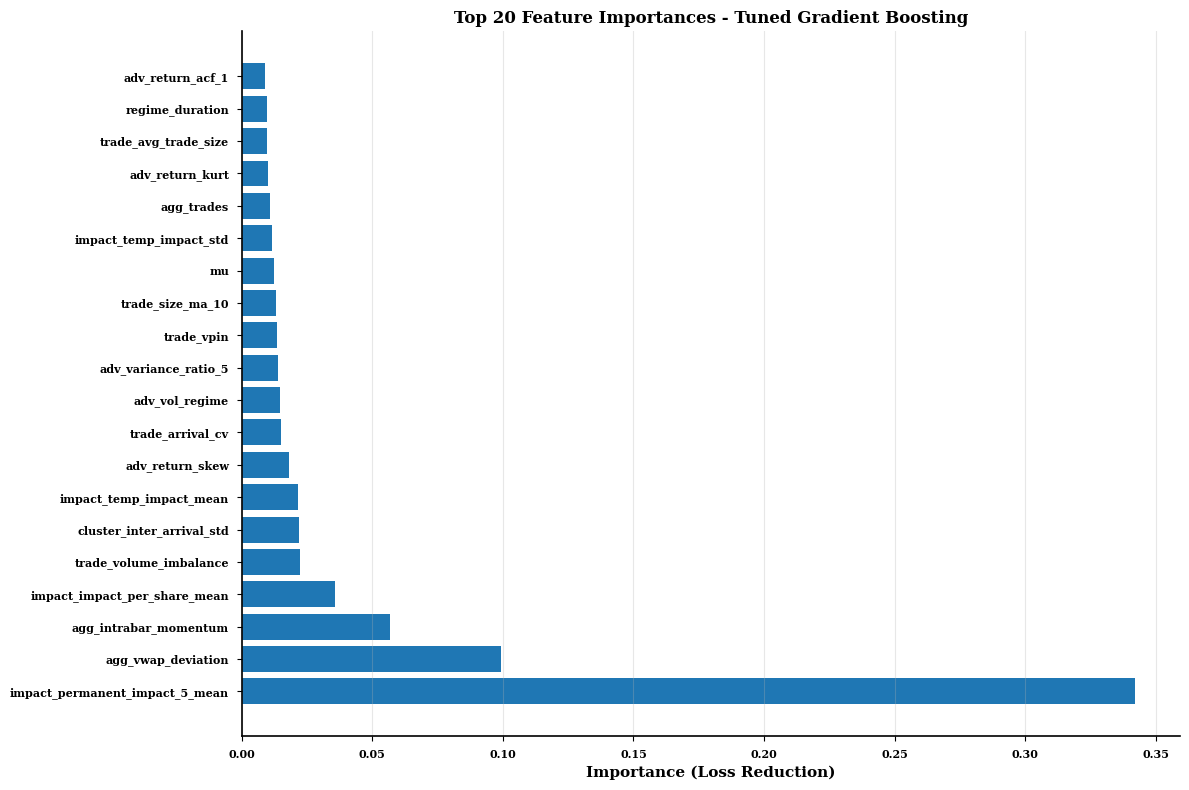


 Saved to /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/figures/gradient_boosting/feature_importance.png


In [13]:
# Visualize feature importance
fig, ax = plt.subplots(figsize=(12, 8))

top_features = feature_importance.head(20)
ax.barh(range(len(top_features)), top_features["importance"].values)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features["feature"].values)
ax.set_xlabel("Importance (Loss Reduction)", fontsize=11)
ax.set_title(
    "Top 20 Feature Importances - Tuned Gradient Boosting",
    fontsize=12,
    fontweight="bold",
)
ax.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.savefig(gb_dir / "feature_importance.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n Saved to {gb_dir / 'feature_importance.png'}")

## 12. Learning Curves - Staged Prediction

Analyze how performance evolves with each boosting iteration


In [14]:
# Calculate staged predictions (performance at each boosting iteration)
print("Computing learning curves (staged predictions)...")

train_scores = []
test_scores = []

for i, (y_train_pred_staged, y_test_pred_staged) in enumerate(
    zip(gb_tuned.staged_predict(X_train), gb_tuned.staged_predict(X_test))
):
    train_scores.append(accuracy_score(y_train, y_train_pred_staged))
    test_scores.append(accuracy_score(y_test, y_test_pred_staged))

# Create learning curves DataFrame
learning_curves = pd.DataFrame(
    {
        "iteration": range(1, len(train_scores) + 1),
        "train_acc": train_scores,
        "test_acc": test_scores,
        "overfit_gap": np.array(train_scores) - np.array(test_scores),
    }
)

print(f"\n Computed learning curves for {len(train_scores)} iterations")
print(f"\nPerformance at key iterations:")
for n in [10, 50, 100, len(train_scores)]:
    if n <= len(train_scores):
        idx = n - 1
        print(
            f"  Iteration {n:3d}: Train={train_scores[idx]:.4f}, Test={test_scores[idx]:.4f}, Gap={train_scores[idx]-test_scores[idx]:.4f}"
        )

Computing learning curves (staged predictions)...

 Computed learning curves for 300 iterations

Performance at key iterations:
  Iteration  10: Train=0.6178, Test=0.5165, Gap=0.1013
  Iteration  50: Train=0.7415, Test=0.6227, Gap=0.1188
  Iteration 100: Train=0.7544, Test=0.6374, Gap=0.1170
  Iteration 300: Train=0.8203, Test=0.6447, Gap=0.1757


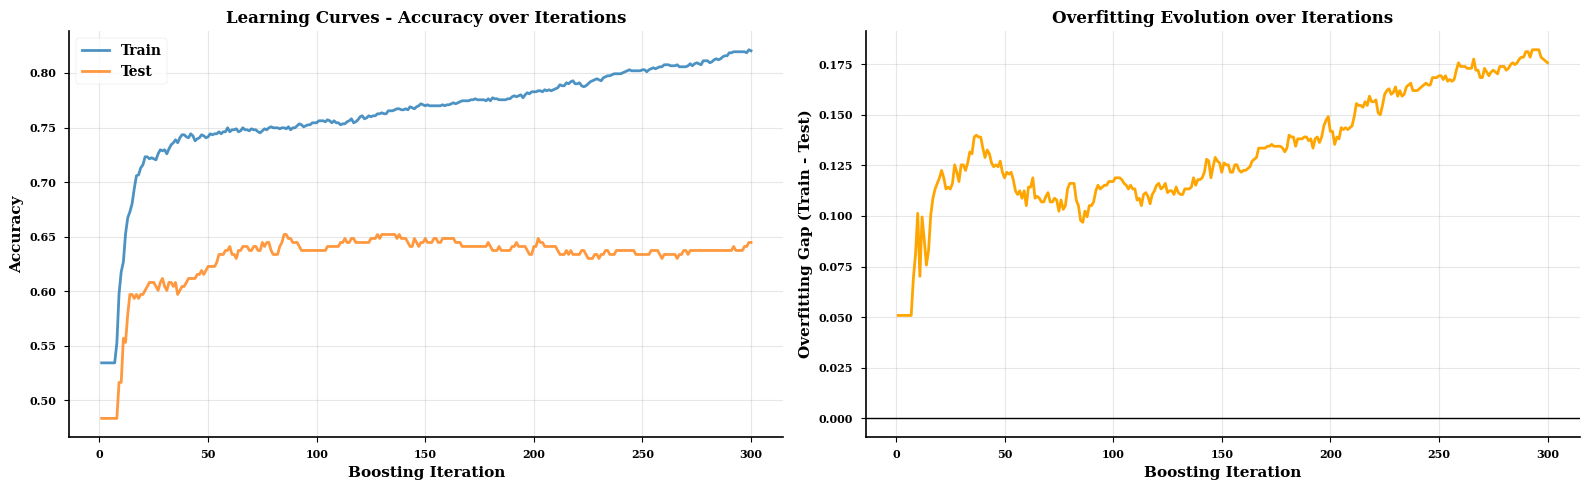


 Saved to /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/figures/gradient_boosting/learning_curves.png


In [15]:
# Plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Accuracy over iterations
axes[0].plot(
    learning_curves["iteration"],
    learning_curves["train_acc"],
    linewidth=2,
    label="Train",
    alpha=0.8,
)
axes[0].plot(
    learning_curves["iteration"],
    learning_curves["test_acc"],
    linewidth=2,
    label="Test",
    alpha=0.8,
)
axes[0].set_xlabel("Boosting Iteration", fontsize=11)
axes[0].set_ylabel("Accuracy", fontsize=11)
axes[0].set_title(
    "Learning Curves - Accuracy over Iterations", fontsize=12, fontweight="bold"
)
axes[0].legend(fontsize=10)
axes[0].grid(alpha=0.3)

# Plot 2: Overfitting gap over iterations
axes[1].plot(
    learning_curves["iteration"],
    learning_curves["overfit_gap"],
    linewidth=2,
    color="orange",
)
axes[1].axhline(y=0, color="black", linestyle="-", linewidth=1)
axes[1].set_xlabel("Boosting Iteration", fontsize=11)
axes[1].set_ylabel("Overfitting Gap (Train - Test)", fontsize=11)
axes[1].set_title(
    "Overfitting Evolution over Iterations", fontsize=12, fontweight="bold"
)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(gb_dir / "learning_curves.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n Saved to {gb_dir / 'learning_curves.png'}")

## 13. Confusion Matrix and ROC Curve


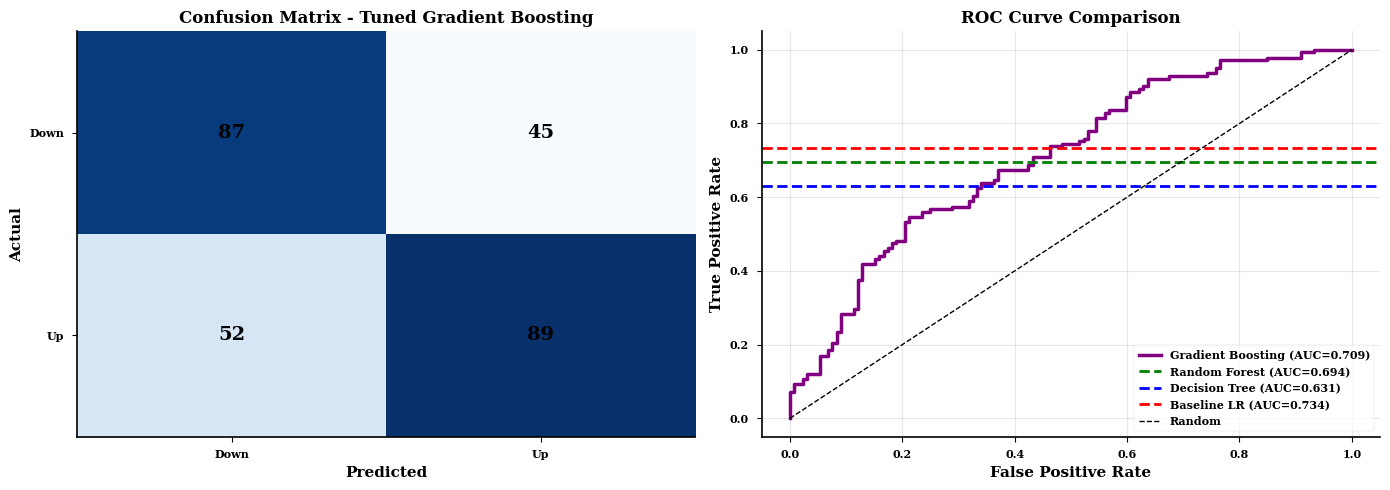


 Saved to /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/figures/gradient_boosting/performance.png


In [16]:
# Create performance visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_tuned)
im = axes[0].imshow(cm, cmap="Blues", aspect="auto")
axes[0].set_title(
    "Confusion Matrix - Tuned Gradient Boosting", fontsize=12, fontweight="bold"
)
axes[0].set_xlabel("Predicted", fontsize=11)
axes[0].set_ylabel("Actual", fontsize=11)
axes[0].set_xticks([0, 1])
axes[0].set_yticks([0, 1])
axes[0].set_xticklabels(["Down", "Up"])
axes[0].set_yticklabels(["Down", "Up"])

# Annotate cells
for row in range(2):
    for col in range(2):
        axes[0].text(
            col,
            row,
            str(cm[row, col]),
            ha="center",
            va="center",
            fontsize=14,
            fontweight="bold",
        )

# ROC curve - compare all models
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_test_proba_tuned)
axes[1].plot(
    fpr_gb,
    tpr_gb,
    linewidth=2.5,
    label=f"Gradient Boosting (AUC={test_auc_tuned:.3f})",
    color="purple",
)
axes[1].axhline(
    y=rf_results["rf_tuned"]["test_roc_auc"],
    color="green",
    linestyle="--",
    linewidth=2,
    label=f"Random Forest (AUC={rf_results['rf_tuned']['test_roc_auc']:.3f})",
)
axes[1].axhline(
    y=dt_results["dt_tuned"]["test_roc_auc"],
    color="blue",
    linestyle="--",
    linewidth=2,
    label=f"Decision Tree (AUC={dt_results['dt_tuned']['test_roc_auc']:.3f})",
)
axes[1].axhline(
    y=baseline_results["lr_l2"]["test_roc_auc"],
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Baseline LR (AUC={baseline_results['lr_l2']['test_roc_auc']:.3f})",
)
axes[1].plot([0, 1], [0, 1], "k--", linewidth=1, label="Random")
axes[1].set_xlabel("False Positive Rate", fontsize=11)
axes[1].set_ylabel("True Positive Rate", fontsize=11)
axes[1].set_title("ROC Curve Comparison", fontsize=12, fontweight="bold")
axes[1].legend(loc="lower right", fontsize=8)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(gb_dir / "performance.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n Saved to {gb_dir / 'performance.png'}")

## 14. Comprehensive Model Comparison


In [17]:
# Create comprehensive comparison
comparison_data = {
    "Model": [
        "Logistic Reg (L2)",
        "Decision Tree",
        "Random Forest",
        "Gradient Boosting",
    ],
    "Accuracy": [
        baseline_results["lr_l2"]["test_accuracy"],
        dt_results["dt_tuned"]["test_accuracy"],
        rf_results["rf_tuned"]["test_accuracy"],
        test_acc_tuned,
    ],
    "F1-Score": [
        baseline_results["lr_l2"]["test_f1"],
        dt_results["dt_tuned"]["test_f1"],
        rf_results["rf_tuned"]["test_f1"],
        test_f1_tuned,
    ],
    "ROC-AUC": [
        baseline_results["lr_l2"]["test_roc_auc"],
        dt_results["dt_tuned"]["test_roc_auc"],
        rf_results["rf_tuned"]["test_roc_auc"],
        test_auc_tuned,
    ],
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "=" * 80)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Identify best model for each metric
print("\nBest models by metric:")
for metric in ["Accuracy", "F1-Score", "ROC-AUC"]:
    best_idx = comparison_df[metric].idxmax()
    best_model = comparison_df.loc[best_idx, "Model"]
    best_score = comparison_df.loc[best_idx, metric]
    print(f"  {metric:12s}: {best_model:25s} ({best_score:.4f})")


COMPREHENSIVE MODEL COMPARISON
            Model  Accuracy  F1-Score  ROC-AUC
Logistic Reg (L2)  0.681319  0.666667 0.733720
    Decision Tree  0.637363  0.668896 0.631259
    Random Forest  0.630037  0.635379 0.694498
Gradient Boosting  0.644689  0.647273 0.708629

Best models by metric:
  Accuracy    : Logistic Reg (L2)         (0.6813)
  F1-Score    : Decision Tree             (0.6689)
  ROC-AUC     : Logistic Reg (L2)         (0.7337)


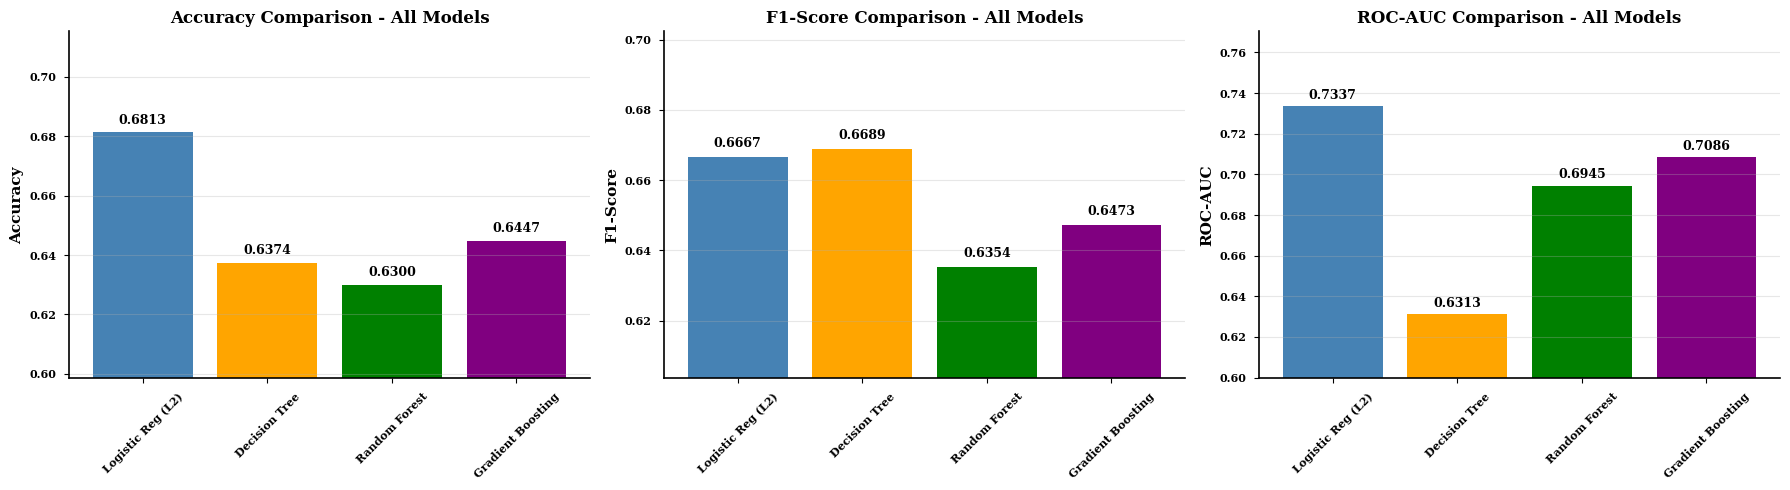


 Saved to /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/figures/gradient_boosting/model_comparison.png


In [18]:
# Plot comprehensive comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ["Accuracy", "F1-Score", "ROC-AUC"]
colors = ["steelblue", "orange", "green", "purple"]

for i, metric in enumerate(metrics):
    axes[i].bar(comparison_df["Model"], comparison_df[metric], color=colors)
    axes[i].set_ylabel(metric, fontsize=11)
    axes[i].set_title(
        f"{metric} Comparison - All Models", fontsize=12, fontweight="bold"
    )
    axes[i].set_ylim(
        [min(comparison_df[metric]) * 0.95, max(comparison_df[metric]) * 1.05]
    )
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].grid(axis="y", alpha=0.3)

    # Annotate bars
    for j, v in enumerate(comparison_df[metric]):
        axes[i].text(
            j,
            v + 0.002,
            f"{v:.4f}",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold",
        )

plt.tight_layout()
plt.savefig(gb_dir / "model_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"\n Saved to {gb_dir / 'model_comparison.png'}")

## 15. Save Models and Results


In [19]:
# Save models
with open(MODELS_DIR / "gradient_boosting_tuned.pkl", "wb") as f:
    pickle.dump(gb_tuned, f)
with open(MODELS_DIR / "gradient_boosting_baseline.pkl", "wb") as f:
    pickle.dump(gb_baseline, f)

print(" Models saved:")
print(f"  {MODELS_DIR / 'gradient_boosting_tuned.pkl'}")
print(f"  {MODELS_DIR / 'gradient_boosting_baseline.pkl'}")

 Models saved:
  /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../models/gradient_boosting_tuned.pkl
  /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../models/gradient_boosting_baseline.pkl


In [20]:
# Save results
results = {
    "ticker": TICKER,
    "start_date": START_DATE,
    "end_date": END_DATE,
    "date_range": DATE_RANGE,
    "gb_baseline": {
        "train_accuracy": float(accuracy_score(y_train, y_train_pred_base)),
        "test_accuracy": float(accuracy_score(y_test, y_test_pred_base)),
        "test_precision": float(precision_score(y_test, y_test_pred_base)),
        "test_recall": float(recall_score(y_test, y_test_pred_base)),
        "test_f1": float(f1_score(y_test, y_test_pred_base)),
        "test_roc_auc": float(roc_auc_score(y_test, y_test_proba_base)),
        "n_estimators": int(gb_baseline.n_estimators),
        "learning_rate": float(gb_baseline.learning_rate),
    },
    "gb_tuned": {
        "train_accuracy": float(accuracy_score(y_train, y_train_pred_tuned)),
        "test_accuracy": float(test_acc_tuned),
        "test_precision": float(precision_score(y_test, y_test_pred_tuned)),
        "test_recall": float(recall_score(y_test, y_test_pred_tuned)),
        "test_f1": float(test_f1_tuned),
        "test_roc_auc": float(test_auc_tuned),
        "train_test_gap": float(train_test_gap),
        "best_params": random_search.best_params_,
        "cv_f1_score": float(random_search.best_score_),
    },
    "improvement_over_baseline": {
        "accuracy": float(acc_improvement_base),
        "f1": float(f1_improvement_base),
        "roc_auc": float(auc_improvement_base),
        "accuracy_pct": float(
            100 * acc_improvement_base / baseline_results["lr_l2"]["test_accuracy"]
        ),
        "f1_pct": float(
            100 * f1_improvement_base / baseline_results["lr_l2"]["test_f1"]
        ),
        "roc_auc_pct": float(
            100 * auc_improvement_base / baseline_results["lr_l2"]["test_roc_auc"]
        ),
    },
    "improvement_over_decision_tree": {
        "accuracy": float(acc_improvement_dt),
        "f1": float(f1_improvement_dt),
        "roc_auc": float(auc_improvement_dt),
        "accuracy_pct": float(
            100 * acc_improvement_dt / dt_results["dt_tuned"]["test_accuracy"]
        ),
        "f1_pct": float(100 * f1_improvement_dt / dt_results["dt_tuned"]["test_f1"]),
        "roc_auc_pct": float(
            100 * auc_improvement_dt / dt_results["dt_tuned"]["test_roc_auc"]
        ),
    },
    "comparison_to_random_forest": {
        "accuracy": float(acc_improvement_rf),
        "f1": float(f1_improvement_rf),
        "roc_auc": float(auc_improvement_rf),
        "accuracy_pct": float(
            100 * acc_improvement_rf / rf_results["rf_tuned"]["test_accuracy"]
        ),
        "f1_pct": float(100 * f1_improvement_rf / rf_results["rf_tuned"]["test_f1"]),
        "roc_auc_pct": float(
            100 * auc_improvement_rf / rf_results["rf_tuned"]["test_roc_auc"]
        ),
    },
    "learning_rate_analysis": lr_df.to_dict("records"),
}

with open(MODELS_DIR / "gradient_boosting_results.json", "w") as f:
    json.dump(results, f, indent=2)

print(f"\n Results saved to {MODELS_DIR / 'gradient_boosting_results.json'}")
print(f"\nResults summary:")
print(f"  Ticker: {TICKER}")
print(f"  Date range: {START_DATE} to {END_DATE} (5 trading days)")
print(f"  Train samples: {len(X_train):,}")
print(f"  Test samples: {len(X_test):,}")


 Results saved to /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../models/gradient_boosting_results.json

Results summary:
  Ticker: AAPL
  Date range: 2024-12-09 to 2024-12-13 (5 trading days)
  Train samples: 1,091
  Test samples: 273


In [21]:
# Save tables
feature_importance.to_csv(TABLES_DIR / "gb_feature_importance.csv", index=False)
lr_df.to_csv(TABLES_DIR / "gb_learning_rate_analysis.csv", index=False)
learning_curves.to_csv(TABLES_DIR / "gb_learning_curves.csv", index=False)
comparison_df.to_csv(TABLES_DIR / "all_models_comparison.csv", index=False)

print(" Tables saved:")
print(f"  {TABLES_DIR / 'gb_feature_importance.csv'}")
print(f"  {TABLES_DIR / 'gb_learning_rate_analysis.csv'}")
print(f"  {TABLES_DIR / 'gb_learning_curves.csv'}")
print(f"  {TABLES_DIR / 'all_models_comparison.csv'}")

 Tables saved:
  /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/tables/gb_feature_importance.csv
  /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/tables/gb_learning_rate_analysis.csv
  /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/tables/gb_learning_curves.csv
  /Users/rylanspence/Desktop/Git/HF/HFT-Equity-Prediction-Pipeline/notebooks/../reports/tables/all_models_comparison.csv


## 16. Summary


In [22]:
print("=" * 80)
print(f"GRADIENT BOOSTING ANALYSIS SUMMARY - {TICKER} ({START_DATE} to {END_DATE})")
print("=" * 80)

print(f"\nData Coverage:")
print(f"  Date range: {START_DATE} to {END_DATE} (5 trading days)")
print(f"  Train samples: {len(X_train):,}")
print(f"  Test samples: {len(X_test):,}")
print(f"  Features: {len(feature_cols)}")

print(f"\nBaseline Gradient Boosting (100 estimators):")
print(f"  Test Accuracy: {results['gb_baseline']['test_accuracy']:.4f}")
print(f"  Test F1-score: {results['gb_baseline']['test_f1']:.4f}")
print(f"  Test ROC-AUC:  {results['gb_baseline']['test_roc_auc']:.4f}")

print(f"\nTuned Gradient Boosting:")
print(f"  Test Accuracy: {results['gb_tuned']['test_accuracy']:.4f}")
print(f"  Test F1-score: {results['gb_tuned']['test_f1']:.4f}")
print(f"  Test ROC-AUC:  {results['gb_tuned']['test_roc_auc']:.4f}")

print(f"\nBest Hyperparameters:")
for param, value in results["gb_tuned"]["best_params"].items():
    print(f"  {param}: {value}")

print(f"\nImprovement over Baseline (Logistic Regression L2):")
print(
    f"  Accuracy:  {results['improvement_over_baseline']['accuracy']:+.4f} ({results['improvement_over_baseline']['accuracy_pct']:+.1f}%)"
)
print(
    f"  F1-score:  {results['improvement_over_baseline']['f1']:+.4f} ({results['improvement_over_baseline']['f1_pct']:+.1f}%)"
)
print(
    f"  ROC-AUC:   {results['improvement_over_baseline']['roc_auc']:+.4f} ({results['improvement_over_baseline']['roc_auc_pct']:+.1f}%)"
)

print(f"\nImprovement over Decision Tree:")
print(
    f"  Accuracy:  {results['improvement_over_decision_tree']['accuracy']:+.4f} ({results['improvement_over_decision_tree']['accuracy_pct']:+.1f}%)"
)
print(
    f"  F1-score:  {results['improvement_over_decision_tree']['f1']:+.4f} ({results['improvement_over_decision_tree']['f1_pct']:+.1f}%)"
)
print(
    f"  ROC-AUC:   {results['improvement_over_decision_tree']['roc_auc']:+.4f} ({results['improvement_over_decision_tree']['roc_auc_pct']:+.1f}%)"
)

print(f"\nComparison to Random Forest (Boosting vs. Bagging):")
print(
    f"  Accuracy:  {results['comparison_to_random_forest']['accuracy']:+.4f} ({results['comparison_to_random_forest']['accuracy_pct']:+.1f}%)"
)
print(
    f"  F1-score:  {results['comparison_to_random_forest']['f1']:+.4f} ({results['comparison_to_random_forest']['f1_pct']:+.1f}%)"
)
print(
    f"  ROC-AUC:   {results['comparison_to_random_forest']['roc_auc']:+.4f} ({results['comparison_to_random_forest']['roc_auc_pct']:+.1f}%)"
)

print(f"\nKey Insights:")
best_model = comparison_df.loc[comparison_df["F1-Score"].idxmax(), "Model"]
print(f"  - Best overall model: {best_model}")
print(
    f"  - Sequential boosting {'outperforms' if test_f1_tuned > rf_results['rf_tuned']['test_f1'] else 'underperforms'} parallel bagging"
)
print(
    f"  - Learning curves show {'convergence' if learning_curves['test_acc'].iloc[-10:].std() < 0.001 else 'ongoing improvement'}"
)
print(
    f"  - Top 10 features account for {100*feature_importance.head(10)['importance'].sum():.1f}% of importance"
)
print(
    f"  - Train-test gap: {results['gb_tuned']['train_test_gap']:.4f} ({'well-regularized' if results['gb_tuned']['train_test_gap'] < 0.05 else 'some overfitting'})"
)
print(f"  - Analysis covers 5 trading days ({START_DATE} to {END_DATE})")

print(f"\nNext Steps:")
print(f"  - Notebook 55: Regime-conditional models (train separate models per regime)")
print(f"  - Notebook 60: Feature importance analysis (permutation, SHAP)")
print(f"  - Notebook 65: Model interpretability (decision paths, PDPs)")

print("\n" + "=" * 80)

GRADIENT BOOSTING ANALYSIS SUMMARY - AAPL (2024-12-09 to 2024-12-13)

Data Coverage:
  Date range: 2024-12-09 to 2024-12-13 (5 trading days)
  Train samples: 1,091
  Test samples: 273
  Features: 81

Baseline Gradient Boosting (100 estimators):
  Test Accuracy: 0.6740
  Test F1-score: 0.6564
  Test ROC-AUC:  0.7144

Tuned Gradient Boosting:
  Test Accuracy: 0.6447
  Test F1-score: 0.6473
  Test ROC-AUC:  0.7086

Best Hyperparameters:
  subsample: 0.8
  n_estimators: 300
  min_samples_split: 100
  min_samples_leaf: 50
  max_depth: 5
  learning_rate: 0.01

Improvement over Baseline (Logistic Regression L2):
  Accuracy:  -0.0366 (-5.4%)
  F1-score:  -0.0194 (-2.9%)
  ROC-AUC:   -0.0251 (-3.4%)

Improvement over Decision Tree:
  Accuracy:  +0.0073 (+1.1%)
  F1-score:  -0.0216 (-3.2%)
  ROC-AUC:   +0.0774 (+12.3%)

Comparison to Random Forest (Boosting vs. Bagging):
  Accuracy:  +0.0147 (+2.3%)
  F1-score:  +0.0119 (+1.9%)
  ROC-AUC:   +0.0141 (+2.0%)

Key Insights:
  - Best overall model: 